In [1]:
import argparse
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

In [2]:
class Network:
    """
    Graph structure for the analysis of the input network
    """
    def __init__(self, file_path):
        """The constructor of the Network class.
        It parses the input file and generates a graph.

        Args:
            file_path (str): The path of the input file
        """
        self.adj = defaultdict(list)
        self.connected = defaultdict(list)
        self.fd = open(file_path, "r", encoding='UTF8')  
        
        for line in self.fd.readlines():
            _line = line.rstrip().split("\t")
            self.connected[int(_line[0])].append(int(_line[1])) 
            self.adj[int(_line[0])].append(int(_line[1]))
            self.adj[int(_line[1])].append(int(_line[0])) 
                
    def nodes(self):
        return self.adj.keys()
    
    def neighbors(self, x):
        return self.adj[x]
    
    def isConnected(self, x, y):
        if(y in self.connected[x]):
            return True
        else:
            return False

In [3]:
def ESU(G, k):
    """
    Collects all k-size subgraphs in G (without distinguishing different kinds of motifs)
    """
    k_subgraphs = []
    for v in list(G.nodes()):
        v_extension = set([u for u in G.neighbors(v) if u > v]) # Property 1: u's node_id must be larger than that of v
        extendSubgraph(G, set([v]), v_extension, v, k, k_subgraphs)
    return k_subgraphs

def extendSubgraph(G, v_subgraph, v_extension, v, k, k_subgraphs):
    """
    G: A whole network (Same input with the G in ESU)
    v_subgraph: currently constructed subgraph
    v_extension: set of candidate nodes to extend the motif 
    k: Get all 'k-size' subgraphs in G
    k_subgraphs: empty list to be filled later with v_subgraph 
    """

    if (len(v_subgraph) == k): # Termination criteria
        k_subgraphs.append(v_subgraph)
        return
    while (len(v_extension) > 0):
        w = random.choice(tuple(v_extension)) 
        v_extension.remove(w) # E3 on Slide 36 of Chapter3
        a = exclusiveNeighborhood(G, w, v_subgraph) # Get N_{excl}(w, V_{subgraph}) which will be used on E4 on Slide 36 of Chapter3
        vpExtension = v_extension | set([u for u in a if u > v]) # E4 on Slide 36 of Chapter3
        extendSubgraph(G, v_subgraph | set([w]), vpExtension, v, k, k_subgraphs)
    return
        
# Property 2: u may only be neighbored to w but not any node already in V_{subgraph}
def exclusiveNeighborhood(G, w, Vp): # I changed 'v' to 'w' for easy visual recognition.
    Nv = set(G.neighbors(w))
    Nvpll = set([G.neighbors(v) for v in Vp][0])
    return Nv - (Nvpll | set(Vp)) # set(Vp): V_{subgraph } // Nvpll: N(V_{subgraph})

In [4]:
def countMotifs(G, k_subgraphs):
    ######### Task 1. Complete the constructor of Code ##########
    # Given an input graph G and its subgraphs k_subgraphs, count the motifs  
    # return format should be either list or dictionary
    # You may declare any class variable or method if needed
    # E.g., ans[4] should return the number of M_5 in the graph
    #############################################################
    from copy import deepcopy
    """
    G: An input graph
    k_subgraphs: Subgraphs of G
    """

    def motif_per_instance(g, subg):
        subg = list(subg)
        subg_cp = deepcopy(subg)
        motif = -1
        
        while True:
            for itr, start_node in enumerate(subg_cp): # Considering Isomorphism
                subg.remove(start_node)
                node1 = subg[0]
                node2 = subg[1]

                s_to_one = g.isConnected(start_node, node1) # from start node to node1
                s_to_two = g.isConnected(start_node, node2) # from start node to node2
                one_to_s = g.isConnected(node1, start_node) # from node1 to start node
                two_to_s = g.isConnected(node2, start_node) # from node2 to start node
                one_to_two = g.isConnected(node1, node2) # from node1 to node2
                two_to_one = g.isConnected(node2, node1) # from node2 to node1

                # Category1: Motifs which looks like one side is empty. (Motif 1,2,3,4,7,8)
                if not g.isConnected(node1, node2) and not g.isConnected(node2, node1): 
                    if s_to_one and s_to_two: # For motif 1, 3, 8
                        if not one_to_s and not two_to_s:
                            motif = 1
                            break
                        elif (one_to_s and not two_to_s) or (two_to_s and not one_to_s):
                            motif = 3
                            break
                        elif one_to_s and two_to_s:
                            motif = 8
                            break
                    elif one_to_s and two_to_s: # For motif 4, 7
                        if not s_to_one and not s_to_two:
                            motif = 4
                            break
                        elif not (s_to_one and s_to_two):
                            motif = 7
                            break
                    elif (one_to_s and s_to_two) or (two_to_s and s_to_one): # For motif 2
                        motif = 2
                        break
                    else:
                        if itr == 2:
                            raise ValueError('There might be the case that I missed accidently on Motif 1,2,3,4,7,8 during considertaion.')
                        else:
                            pass

                # Category2: Motifs whose in-degree of start node is 2 (Motif 5, 6, 10, 11, 12, 13)
                # Motif 4 is already considered on Category1.
                elif one_to_s and two_to_s:
                    if not s_to_one and not s_to_two: # For motif 5, 6
                        if one_to_two and two_to_one:
                            motif = 6
                            break
                        elif (one_to_two and not two_to_one) or \
                            (two_to_one and not one_to_two):
                            motif = 5
                            break
                        elif not one_to_two and not two_to_one:
                            pass # Motif 4 is already considered at Category1.
                    elif (s_to_one and not s_to_two) or (not s_to_one and s_to_two): # For motif 10, 11, 12
                        if not s_to_one and s_to_two:
                            if one_to_two and not two_to_one:
                                motif = 11
                                break
                            elif not one_to_two and two_to_one:
                                motif = 10
                                break
                            elif one_to_two and two_to_one:
                                motif = 12
                                break
                        else:
                            if one_to_two and not two_to_one:
                                motif = 10
                                break
                            elif not one_to_two and two_to_one:
                                motif = 11
                                break
                            elif one_to_two and two_to_one:
                                motif = 12
                                break
                    elif s_to_one and s_to_two and one_to_two and two_to_one:
                        motif = 13
                        break
                    else:
                        if itr == 2:
                            raise ValueError('There might be the case that I missed accidently on Motif 5,6,10,11,12,13 during consideration.')
                        else:
                            pass
                
                # Category3: Motif which is a cycle (Motif 9)
                elif (s_to_one and one_to_two and two_to_s and not one_to_s and not two_to_one and not s_to_two) or \
                    (s_to_two and two_to_one and one_to_s and not two_to_s and not one_to_two and not s_to_one):
                    motif = 9
                    break

                else:
                    if itr == 2:
                        raise ValueError('Is not involved in any case. There might be problem that you should modify.')
                    else:
                        pass

                subg = deepcopy(subg_cp)

            if motif != -1:
                return motif
            else:
                ValueError('Algorithm Error')

    motif_cnt_dict = defaultdict(int)
    for instance in k_subgraphs:
        motif = motif_per_instance(G, instance)
        motif_cnt_dict[motif] += 1

    motif_cnt_dict = sorted(motif_cnt_dict.items())

    return motif_cnt_dict

In [5]:
# Problem 1: implement the count motif function, which returns the network motif index given an instance corresponding to M_i. 
# Report the absolute counts of each motif M_i (i= 1,···,13) of the given eight graphs.

graph_list = ['email', 'web', 'A', 'B']
graph_motifs = {}

for graph in graph_list:
    # File names of the graphs.
    f_real_graph = './data/' + graph + '.txt'
    f_rand_graph = './data/' + graph + '_random.txt'

    # Generate the graph.
    real_graph = Network(f_real_graph)
    rand_graph = Network(f_rand_graph)

    # Run the ESU algorithm in real graph.
    real_k_subgraphs = ESU(real_graph, 3)
    real_motifs = countMotifs(real_graph, real_k_subgraphs)

    # Run the ESU algorithm in NULL graph.
    rand_k_subgraphs = ESU(rand_graph, 3)
    rand_motifs = countMotifs(rand_graph, rand_k_subgraphs)
    
    # Save the motif counts.
    graph_motifs[graph] = {'real': real_motifs, 'rand': rand_motifs}

In [6]:
def normalizedSignificance(real_motifs, rand_motifs, eps):
     ######### Task 2. Complete the Code ###################################
     # Given an real world graph's motif count and random graph's motif count, return the normalized significance score of each motifs
     # return format should be in list
     # You may declare any class variable or method if needed
     # E.g., ans[4] should return the significance score of M_5 in the graph
     ########################################################################

     def _sanity_check(real, rand):
          """
          There were the cases that specific key which is in one Dict is not in another Dict.
          To faciliate the computation, I added abbreviated key to the Dict. 
          """
          real_only_key = list(set(real.keys()) - set(rand.keys()))
          rand_only_key = list(set(rand.keys()) - set(real.keys()))

          if len(real_only_key) != 0:
               for key in real_only_key:
                    rand[key] = 0
          if len(rand_only_key) != 0:
               for key in rand_only_key:
                    real[key] = 0

          assert len(list(real.keys())) == len(list(rand.keys()))

          real = sorted(real.items())
          rand = sorted(rand.items())

          return real, rand

     real_dict = {k: v for k, v in real_motifs}
     rand_dict = {k: v for k, v in rand_motifs}
     real_value, rand_value = _sanity_check(real_dict, rand_dict)

     real_value = [v for _, v in real_value]
     rand_value = [v for _, v in rand_value]
     

     significance = list(map(lambda x, y: (x-y)/(x+y+eps), real_value, rand_value))
     norm = np.sqrt(sum([x**2 for x in significance])).tolist()
     norm_sig = [x/norm for x in significance]
     
     return norm_sig

In [7]:
# Problem 2-1: Compute the normalized significance of each motif.
NS_email = normalizedSignificance(graph_motifs['email']['real'], graph_motifs['email']['rand'], eps=1)
NS_web = normalizedSignificance(graph_motifs['web']['real'], graph_motifs['web']['rand'], eps=1)
NS_A = normalizedSignificance(graph_motifs['A']['real'], graph_motifs['A']['rand'], eps=1)
NS_B = normalizedSignificance(graph_motifs['B']['real'], graph_motifs['B']['rand'], eps=1)

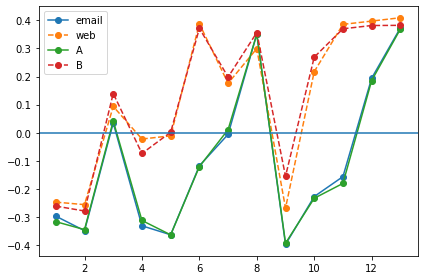

In [8]:
# Problem 2-2: Plot the normalized significance computed above.
plt.plot(list(range(1,14)), NS_email, 'o-', label='email')
plt.plot(list(range(1,14)), NS_web, 'o--', label='web')
plt.plot(list(range(1,14)), NS_A, 'o-', label='A')
plt.plot(list(range(1,14)), NS_B, 'o--', label='B')
plt.axhline(0)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Problem 3: One between A and B is a web graph, and the other is an email. 
# What do you think is a web graph? Provide reasons based on the normalized significance obtained in the previous step.

# The Answer is located at below in a markdown form. 

The red one, 'B' is a web graph, and the other one, 'A' is a email graph.


This judgement is based on the statement: "Networks from the same domain have simailar significance profiles."

Although 'B' and 'web' significance profile graph pair, and 'A' and 'email' significance profile graph pair are not perfectly same, 
but their plot tendence are somewhat aligned. 